In this notebook, we inspect the collaborative behaviour of people taking up the MOOCs. Namely, we look for submissions that are close in time and location.

In [39]:
%matplotlib notebook

import re, itertools, getpass, pymysql.cursors
from collections import Counter
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import deque

In [40]:
def ExecuteQuery(Connector, SQLQuery):

    Cursor = Connector.cursor()
    Cursor.execute(SQLQuery)
    Connector.commit()
    
    ReturnedRows = []

    while True:
        Row = Cursor.fetchone()
        if Row is None:
            break
        else:
            ReturnedRows.append(Row)

    return ReturnedRows

In [41]:
#  Forum_Events                       |
#| Forum_Info                         |
#| Problem_Events_with_Info           |
#| User_Grades                        |
#| User_Location                      |
#| Video_Events                       |
#| Video_Info   

In [42]:
Connector = pymysql.connect(user='hplearn', password='hpl2019', host='cedegemac8.epfl.ch', port=3306, charset='utf8mb4', use_unicode=True)

We first identify the attributes of each database.

In [43]:
database = 'project_how_people_learn'
course_id = 'progfun-2012-001'

# Table columns
forum_events_columns = ['CourseID', 'UserID', 'TimeStamp', 'EventType', 'PostType', 'PostID']
forum_info_columns = ['CourseID', 'PostType', 'PostID', 'ParentPostType', 'ParentPostID']
problem_columns = ['CourseID', 'UserID', 'TimeStamp', 'EventType', 'ProblemType', 'ProblemID', 'SubmissionNumber', 'Grade', 'MaximumSubmissions', 'Title', 'OpenTime','SoftCloseTime', 'HardCloseTime']
user_grades_columns = ['CourseID', 'UserID', 'Grade', 'AchievementLevel', 'Distinction']
user_location_columns = ['CourseID', 'UserID', 'IPAdress', 'City', 'District', 'Country', 'ISO2', 'Region', 'Continent', 'Latitude', 'Longitude', 'TimeZoneOffset']
video_events_columns = ['CourseID', 'UserID', 'TimeStamp', 'EventType', 'VideoID', 'CurrentTime', 'OldTime', 'NewTime', 'SeekType', 'OldSpeed', 'NewSpeed']
video_info_columns = ['CourseID', 'VideoID', 'Title', 'Source', 'Length', 'OpenTime']

In [44]:
# Get data about submissions
out = ExecuteQuery(Connector, f"""
    select *
    from {database}.problem_events_with_info
    where CourseID='{course_id}'
""")

problem_df = pd.DataFrame(out, columns=problem_columns)

In [45]:
# Split Video and Assignment submissions
video_df = problem_df[problem_df['ProblemType'] == 'Video']
assignment_df = problem_df[problem_df['ProblemType'] == 'Assignment']

In [46]:
# Remove assignments with no grade
assignment_df = assignment_df.dropna(subset=['Grade'])

In [47]:
print('Video quizzes sample')
display(video_df.head())
print('Assignment sample')
display(assignment_df.head())

Video quizzes sample


,CourseID,UserID,TimeStamp,EventType,ProblemType,ProblemID,SubmissionNumber,Grade,MaximumSubmissions,Title,OpenTime,SoftCloseTime,HardCloseTime
0,progfun-2012-001,189749                                        ...,1348748287,Problem.Check,Video,42                              ,2,NaN,100.0,Lecture 2.2 - Higher-Order Functions (10:18),1.347969e+09,1.348574e+09,1.349784e+09
1,progfun-2012-001,3153                                          ...,1349290699,Problem.Check,Video,60                              ,1,NaN,100.0,Lecture 3.5 - How Classes Are Organized (20:30),1.349165e+09,1.349360e+09,1.350570e+09
2,progfun-2012-001,1336423                                       ...,1348237598,Problem.Check,Video,7                               ,7,NaN,0.0,Lecture 1.2 - Elements of Programming (14:25),3.240000e+04,2.147484e+09,2.147484e+09
3,progfun-2012-001,1780444                                       ...,1352990521,Problem.Check,Video,11                              ,1,NaN,0.0,Lecture 1.6 - Blocks and Lexical Scope (8:00),0.000000e+00,2.147484e+09,2.147484e+09
4,progfun-2012-001,1355757                                       ...,1349559280,Problem.Check,Video,56                              ,3,NaN,100.0,Lecture 3.3 - Evaluation and Operators (16:25),1.349165e+09,1.349073e+09,1.350282e+09


Assignment sample


,CourseID,UserID,TimeStamp,EventType,ProblemType,ProblemID,SubmissionNumber,Grade,MaximumSubmissions,Title,OpenTime,SoftCloseTime,HardCloseTime
7,progfun-2012-001,1363859                                       ...,1350002205,Problem.Check,Assignment,14                              ,6,98.500004,0.0,Huffman Coding / Huffman Coding,1.349793e+09,1.351235e+09,1.351584e+09
9,progfun-2012-001,79240                                         ...,1350920280,Problem.Check,Assignment,12                              ,1,92.700005,0.0,Object-Oriented Sets / Object-Oriented Sets,1.349177e+09,1.350025e+09,1.350371e+09
21,progfun-2012-001,159787                                        ...,1349076964,Problem.Check,Assignment,6                               ,1,80.000000,0.0,Functional Sets / Functional Sets,1.349090e+09,1.349420e+09,1.349766e+09
23,progfun-2012-001,21504                                         ...,1351416997,Problem.Check,Assignment,17                              ,2,100.000000,0.0,Anagrams / Anagrams,1.351019e+09,1.352063e+09,1.352408e+09
24,progfun-2012-001,1345170                                       ...,1353045887,Problem.Check,Assignment,20                              ,1,100.000000,0.0,Bloxorz / Bloxorz,1.351643e+09,1.353272e+09,1.353618e+09


In [48]:
# Get user location data
out = ExecuteQuery(Connector, f"""
    select *
    from {database}.user_location
    where CourseID='{course_id}'
""")

location_df = pd.DataFrame(out, columns=user_location_columns)

In [49]:
# Remove the user's whose location is unknown
location_df = location_df.dropna(subset=['Latitude', 'Longitude'])

In [50]:
print('Location sample')
location_df.head()

Location sample


,CourseID,UserID,IPAdress,City,District,Country,ISO2,Region,Continent,Latitude,Longitude,TimeZoneOffset
0,progfun-2012-001,1                                             ...,76.126.213.154                                ...,Santa Clara,California,United States,US,North America,Americas,37.3541,-121.95500,-7.0
1,progfun-2012-001,1000012                                       ...,203.36.67.252                                 ...,Southport,Queensland,Australia,AU,Pacific,Oceania,-27.9689,153.41700,10.0
2,progfun-2012-001,100002                                        ...,89.180.138.23                                 ...,Oeiras,Lisbon,Portugal,PT,South West Europe,Europe,38.7270,-9.24199,0.0
3,progfun-2012-001,100009                                        ...,129.253.54.224                                ...,Irvine,California,United States,US,North America,Americas,33.6735,-117.84000,-7.0
8,progfun-2012-001,1000259                                       ...,178.172.15.160                                ...,Ljubljana,Slovenia,Slovenia,SI,South East Europe,Europe,46.0364,14.48960,1.0


### Collaboration within cities

We will first group the users by city and check for their submission behaviour within these clusters. We begin by extracting the submissions by city.

In [51]:
# Determine cities
cities = location_df['City'].unique()
# Split dataframe in city clusters
city_dfs = {}
for city in cities:
    city_dfs[city] = location_df[location_df['City'] == city]

In [52]:
# Get the number of users per city
num_users = []
for city in cities:
    num_users.append((len(city_dfs[city]), city))
num_users = sorted(num_users, reverse=True)

# Display the top 10 cities
print('The top 10 cities in terms of number of users are:')
for i in range(10):
    print(f'{num_users[i][1]}:\t{num_users[i][0]}')
print(f'The total number of users is {len(location_df)}.')

The top 10 cities in terms of number of users are:
London:	837
Moscow:	659
Santa Clara:	583
New York:	564
Madrid:	376
Kiev:	375
Stockholm:	374
New York (Manhattan):	369
New Delhi:	358
Mumbai:	344
The total number of users is 44755.


In [53]:
# Get the users who took video quizzes and solved assignments by city
video_users = video_df['UserID'].unique()
assignment_users = assignment_df['UserID'].unique()

video_city_dfs = {}
assignment_city_dfs = {}
for city in cities:
    city_df = city_dfs[city]
    # Video
    df = city_df[city_df['UserID'].isin(video_users)]
    # Keep city only if it has more than 1 user
    if len(df) > 1:
        video_city_dfs[city] = df
    
    # Assignemnt
    df = city_df[city_df['UserID'].isin(assignment_users)]
    # Keep city only if it has more than 1 user
    if len(df) > 1:
        assignment_city_dfs[city] = df

In [54]:
max_video_users = max([len(video_city_dfs[city]) for city in video_city_dfs])
max_assignment_users = max([len(assignment_city_dfs[city]) for city in assignment_city_dfs])

print(f'The maximum number of users submitting video quizzes in a city is {max_video_users}')
print(f'The maximum number of users submitting assignments in a city is {max_assignment_users}')

The maximum number of users submitting video quizzes in a city is 441
The maximum number of users submitting assignments in a city is 366


In [55]:
# Get submissions per city and sort them by timestamp
video_sub_dfs = {}
assignment_sub_dfs = {}

for city in video_city_dfs:
    city_users = video_city_dfs[city]['UserID']
    video_sub_dfs[city] = video_df[video_df['UserID'].isin(city_users)].sort_values(by='TimeStamp')
    
for city in assignment_city_dfs:
    city_users = assignment_city_dfs[city]['UserID']
    assignment_sub_dfs[city] = assignment_df[assignment_df['UserID'].isin(city_users)].sort_values(by='TimeStamp')

Now that we have the submissions per city, we will analyse collaboration within each of the cities. We say that two users collaborate if they have more than a number of submissions that take place in the same time window.

In [56]:
def find_collaboration(sub_df, users_dict, time_window, deadline_thresh=None, deadline_type='HardCloseTime'):
    '''
    Generate a cooccurence matrix for users whose submissions occur in the same time window for the same task
    input:  sub_df - dataframe containing submissions
            users_dict - dictionary mapping UserID to an integer
            time_window - time window for which two submissions are considered a collaboration
            deadline_thresh - time before deadline in which we should not count submission overlaps
    output: coorcurence matrix for submissions
    '''
    # Create empty adjacency matrix
    mat = np.zeros((len(users_dict), len(users_dict)))
    # Initialize counter for submissions within deadline threshold
    num_deadline = 0

    # Find people who submit in the same time window
    d = deque([sub_df.iloc[0]])
    t = 1
    while t < len(sub_df):
        # Don't consider submission if it is close to the deadline
        if deadline_thresh is not None:
            time_diff = sub_df.iloc[t][deadline_type] - sub_df.iloc[t]['TimeStamp']
            if time_diff > 0 and time_diff <= deadline_thresh:
                num_deadline += 1
                t += 1
                continue
        while len(d) > 0 and sub_df.iloc[t]['TimeStamp'] - d[0]['TimeStamp'] > time_window:
            # Increase count of collaboration for the user of the submission that's about to be popped out
            old_sub = d.popleft()
            old_user = users_dict[old_sub['UserID']]
            matched_users = []
            for sub in d:
                user = users_dict[sub['UserID']]
                if old_sub['Title'] != sub['Title'] or old_user == user or user in matched_users:
                    continue
                # Mark user as being matched so that we don't count it multiple times within this time window
                matched_users.append(user)
                mat[old_user, user] += 1
                mat[user, old_user] += 1
        d.append(sub_df.iloc[t])
        t += 1

    # Increase the count for the pairs of users whose submissions are still in the deque
    for i in range(len(d) - 1):
        old_sub = d[i]
        old_user = users_dict[old_sub['UserID']]
        matched_users = []
        for j in range(i + 1, len(d)):
            sub = d[j]
            user = users_dict[sub['UserID']]
            if old_sub['Title'] != sub['Title'] or old_user == user or user in matched_users:
                continue
            # Mark user as being matched so that we don't count it multiple times within this time window
            matched_users.append(user)
            mat[old_user, user] += 1
            mat[user, old_user] += 1
    
    return mat, num_deadline

We start by inspecting time windows of one hour, without considering the deadline threshold.

In [57]:
# Set the time window to one hour
time_window = 3600

# Associate user ids to cooccurence matrix indices for each city
users_dicts = {}
reverse_users_dicts = {}
for city in assignment_sub_dfs:
    users_dict = {x:i for i, x in enumerate(assignment_sub_dfs[city]['UserID'].unique())}
    reverse_users_dicts[city] = {users_dict[u]:u for u in users_dict}
    users_dicts[city] = users_dict

# Get the collaboration matrix for each city
assignment_colab = {}
for city in assignment_sub_dfs:
    assignment_colab[city], _ = find_collaboration(assignment_sub_dfs[city], users_dicts[city], time_window)

Let's examine the maximum values of the collaboration counts per city on assignments.

<IPython.core.display.Javascript object>


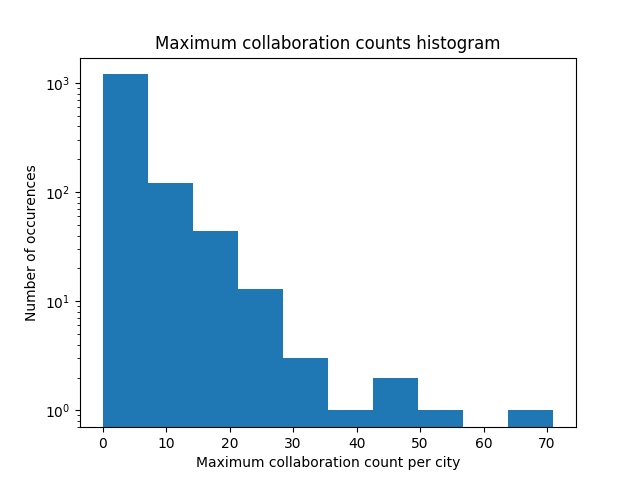

In [58]:
max_colabs = [assignment_colab[city].max() for city in assignment_colab]
plt.hist(max_colabs)
plt.title('Maximum collaboration counts histogram')
plt.xlabel('Maximum collaboration count per city')
plt.ylabel('Number of occurences')
plt.yscale('log');

We notice that most of the maximum values for collaboration counts per city are below 40. This can be because some cities just have to few users. High collaboration counts can be caused by pure coincidence. Another explanation for a high collaboration count could also be that a user has multiple accounts.

Let's identify the city where the maximum collaboration coefficient occurs.

In [59]:
max_colab_count = max(max_colabs)
max_colab_cities = [city for city in assignment_colab if assignment_colab[city].max() == max_colab_count]

print('The cities where we registered the greatest collaboration count are ', max_colab_cities)

The cities where we registered the greatest collaboration count are  ['Lausanne']


As we can see, the maximum collaboration count occurs in Lausanne, which is not so surprising considering that students from EPFL taking the actual course may be the most interested to collaborate for a good grade.

Let's also inspect the overall collaboration counts to find out what would be a good threshold for considering one count to indicate a possible collaboration.

In [60]:
from collections import Counter

# Aggregate collaboration counts
assignment_colab_counter = Counter()
for city in assignment_sub_dfs:
    assignment_colab_counter += Counter(assignment_colab[city].flatten())

<IPython.core.display.Javascript object>


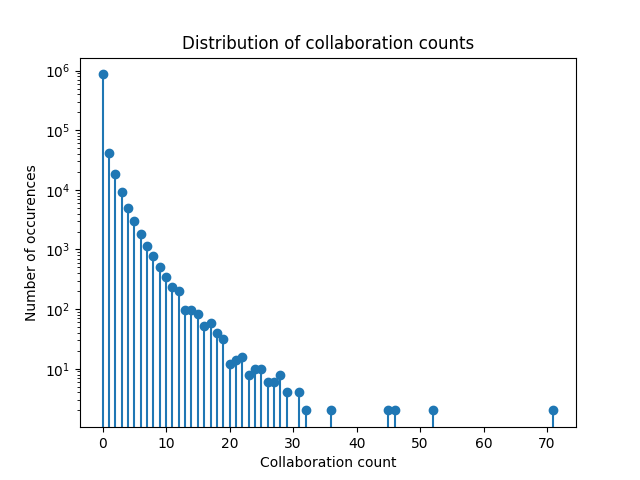

In [61]:
# Plot the number of same time window submissions vs their number of occurences
x = np.array(sorted(list(assignment_colab_counter)))
y = [assignment_colab_counter[count] for count in x]

plt.stem(x, y)
plt.title('Distribution of collaboration counts')
plt.xlabel('Collaboration count')
plt.ylabel('Number of occurences')
plt.yscale('log');

<IPython.core.display.Javascript object>


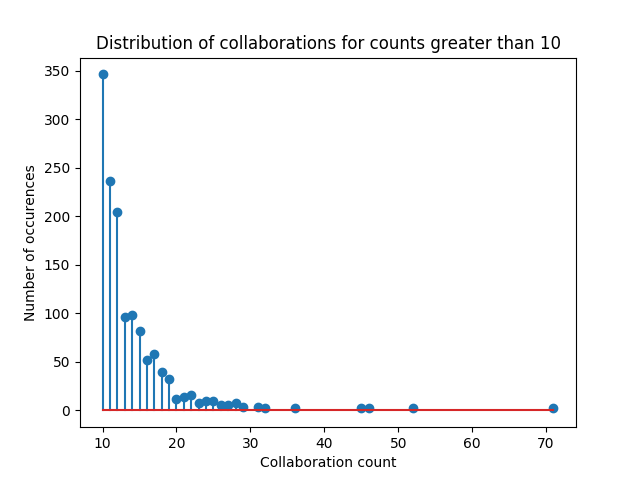

In [62]:
# Plot collaboration counts for a large number of collaborations
large_count_x = x[x>=10]
large_count_y = [assignment_colab_counter[count] for count in large_count_x]

plt.stem(large_count_x, large_count_y)
plt.title('Distribution of collaborations for counts greater than 10')
plt.xlabel('Collaboration count')
plt.ylabel('Number of occurences');

We see that the majority of the time, we don't observe overlaps in the submissions, which is natural. Moreover, given two users, their number of overlaps in submissions, when overlaps happen, is generaly fairly small. By inpecting the plots above, we empirically conisder two users to be collaborating if they have more than 15 submissions in the same timeframe.

There is a total of 374 collaborations in assignments.


<IPython.core.display.Javascript object>


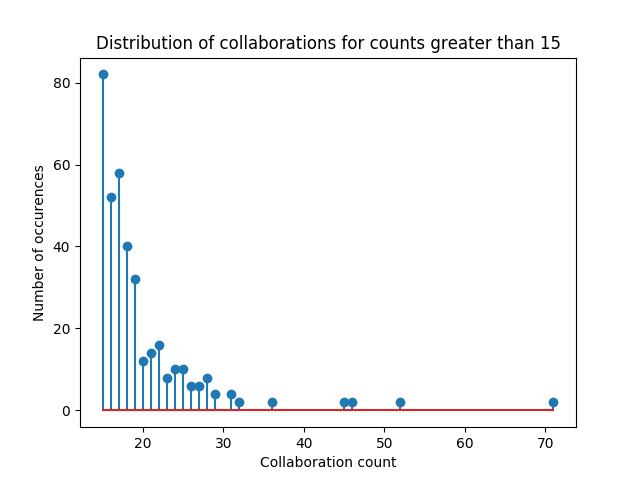

In [63]:
# Get the total number of collaborations
colab_x = x[x>=15]
colab_y = [assignment_colab_counter[count] for count in colab_x]

print(f'There is a total of {np.sum(colab_y)} collaborations in assignments.')

plt.stem(colab_x, colab_y)
plt.title('Distribution of collaborations for counts greater than 15')
plt.xlabel('Collaboration count')
plt.ylabel('Number of occurences');

Let's now check if most of the submission overlaps are due to them being close to the deadline.

In [68]:
def analyse_collaboration(dfs, users_dicts, time_window=3600, deadline_thresh=None, deadline_type='HardCloseTime'):
    '''
    Get collaboration info for each city in the dataset
    input:  dfs - dataframes containing submission data per city
            users_dicts - mapping between user id and matrix index for each city
            time_window - time window to consider for overalapping submissions
            deadline_thresh - time before deadline for which we do not consider submission overlaps
            deadline_type
    output: collaboration count matrices and the number of submission in deadline threshold window
    '''
    # Get the collaboration matrix and number of submissions before deadline for each city
    assignment_colab, assignment_deadline = {}, {}
    for city in assignment_sub_dfs:
        assignment_colab[city], assignment_deadline[city] = find_collaboration(dfs[city], users_dicts[city],
                                                                               time_window, deadline_threshold,
                                                                               deadline_type)
    return assignment_colab, assignment_deadline
        
def plot_collaboration(colab_mats, colab_threshold=15, city=None, title=None):
    '''
    Plot information from the collaboration datasets obtained per city
    input:  colab_mats - cooccurence matrices for collaboration counts per city
            colab_threshold - number of overlaps after which we consider that two users collaborate
            city - the city which to analyse or None if we give overall results
    '''
    # Plot a histogram for maximum collaboration count per city
    if city is None:
        max_colabs = [colab_mats[city].max() for city in colab_mats]
        plt.figure()
        plt.hist(max_colabs)
        plt.title('Maximum collaboration counts histogram')
        plt.xlabel('Maximum collaboration count per city')
        plt.ylabel('Number of occurences')
        plt.yscale('log')
        if title is not None:
            plt.savefig(f'max_{title}.png')
    
    # Plot the number of same time window submissions vs their number of occurences
    assignment_colab_counter = Counter()
    if city is None:
        for city in assignment_sub_dfs:
            assignment_colab_counter += Counter(colab_mats[city].flatten())
    else:
        assignment_colab_counter = Counter(colab_mats[city].flatten())
    x = np.array(sorted(list(assignment_colab_counter)))
    y = [assignment_colab_counter[count] for count in x]
    plt.figure()
    plt.stem(x, y)
    plt.title('Distribution of collaboration counts')
    plt.xlabel('Collaboration count')
    plt.ylabel('Number of occurences')
    plt.yscale('log')
    if title is not None:
        plt.savefig(f'dist_{title}.png')
    
    colab_x = x[x>=colab_threshold]
    colab_y = [assignment_colab_counter[count] for count in colab_x]
    print(f'There is a total of {np.sum(colab_y)} collaborations in assignments.')

In [65]:
deadline_threshold = 24 * 3600
time_window = 3600

# Get collaboration cooccurence matrices for no deadline
no_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window)
# Get collaboration cooccurence matrices for hard deadline
hard_deadline_mats, num_hard = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window,
                                                     deadline_threshold, 'HardCloseTime')
# Get collaboration cooccurence matrices for soft deadline
soft_deadline_mats, num_soft = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window,
                                                     deadline_threshold, 'SoftCloseTime')

In [66]:
total_num_hard = 0
for city in num_hard:
    total_num_hard += num_hard[city]
total_num_soft = 0
for city in num_soft:
    total_num_soft += num_soft[city]
    
print('Number of submissions before hard deadline:', total_num_hard)
print('Number of submissions before soft deadline:', total_num_soft)

Number of submissions before hard deadline: 2552
Number of submissions before soft deadline: 32522



No deadline


<IPython.core.display.Javascript object>


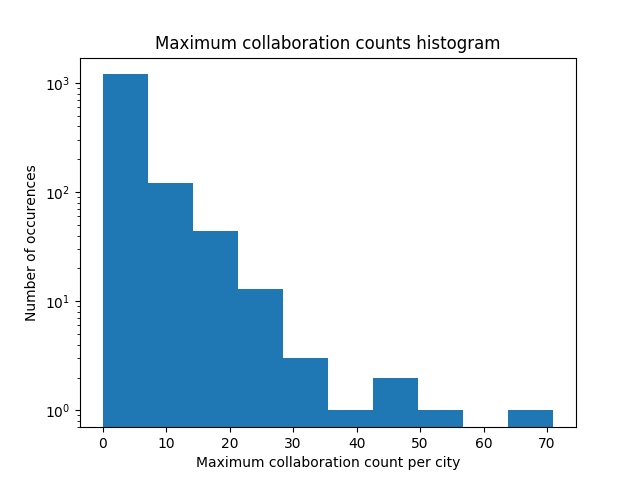

<IPython.core.display.Javascript object>


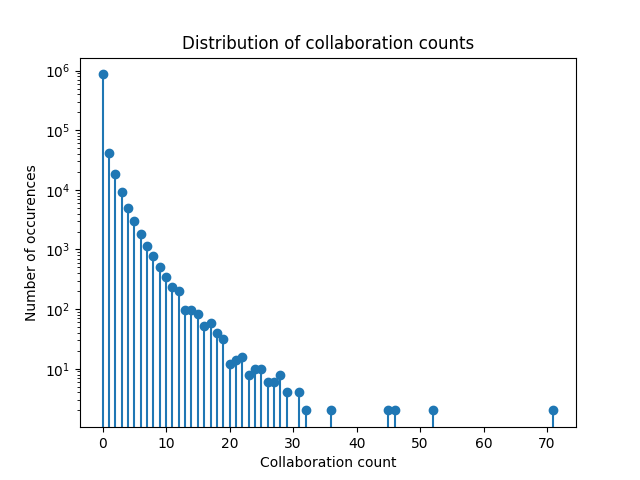

There is a total of 374 collaborations in assignments.

Hard deadline


<IPython.core.display.Javascript object>


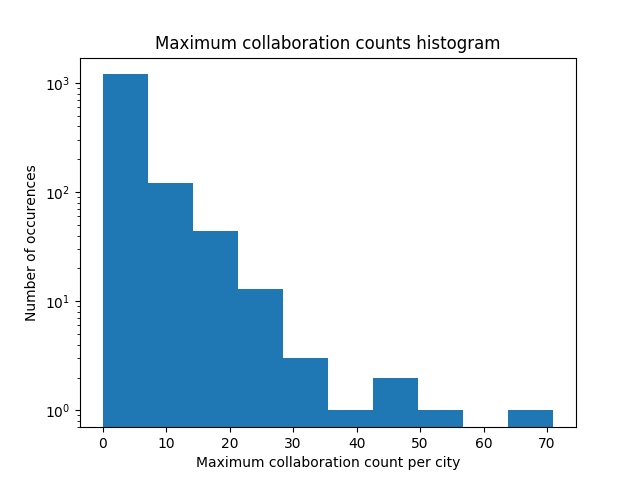

<IPython.core.display.Javascript object>


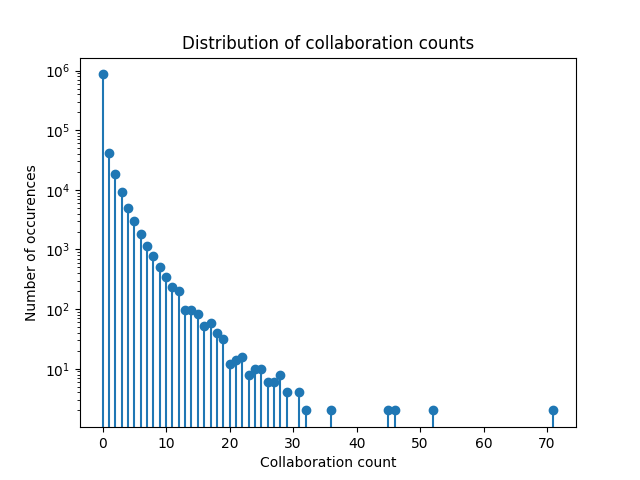

There is a total of 374 collaborations in assignments.

Soft deadline


<IPython.core.display.Javascript object>


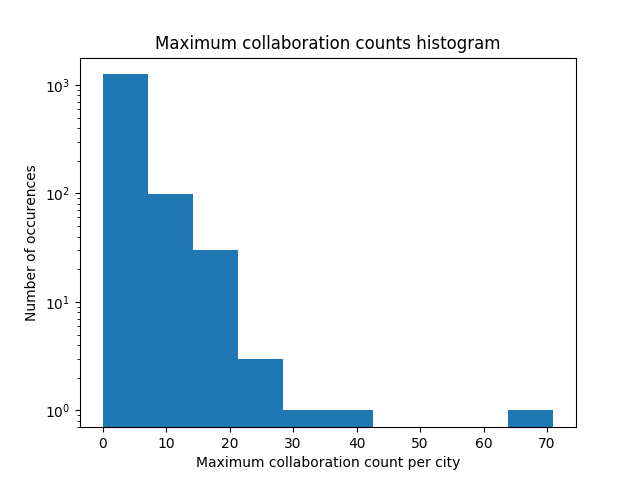

<IPython.core.display.Javascript object>


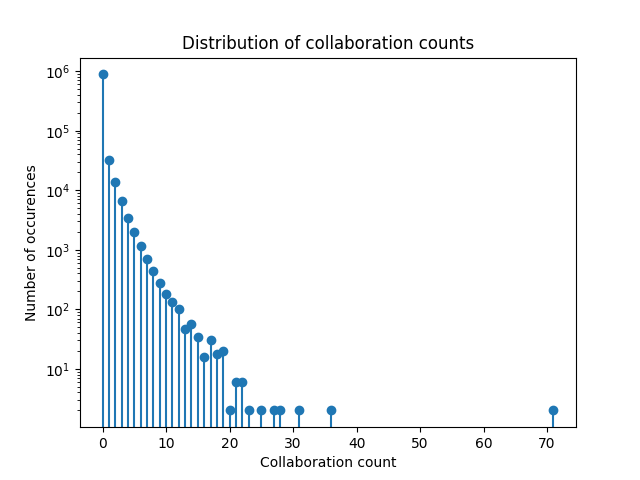

There is a total of 146 collaborations in assignments.


In [70]:
# Draw plots for no deadline
print()
print('No deadline')
plot_collaboration(no_deadline_mats)

# Draw plots for hard deadline
print()
print('Hard deadline')
plot_collaboration(hard_deadline_mats)

# Draw plots for soft deadline
print()
print('Soft deadline')
plot_collaboration(soft_deadline_mats)

As we can see, there are a lot more submissions before the soft deadline than before the hard one.

We note that the distribution when taking into account the hard deadline remains the same. Filtering the submissions before the soft deadline makes the distribution change a little, cutting off from the number of high collaboration counts. The number of collaboration counts above 15 still remains quite high.

Let's take a look at the submissions from Lausanne in particular.

<IPython.core.display.Javascript object>


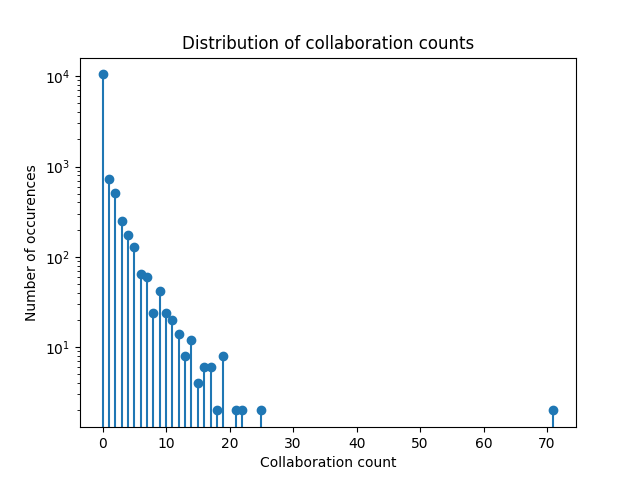

There is a total of 34 collaborations in assignments.
The number of users in Lausanne is 219.


In [71]:
plot_collaboration(soft_deadline_mats, 15, 'Lausanne')
print(f"The number of users in Lausanne is {len(location_df[location_df['City'] == 'Lausanne'])}.")

Now let's investigate the number of collaborations when we decrease the time window size.

No deadline


<IPython.core.display.Javascript object>


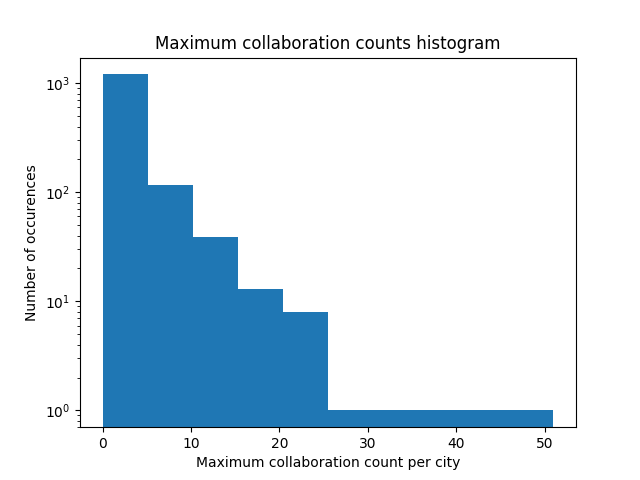

<IPython.core.display.Javascript object>


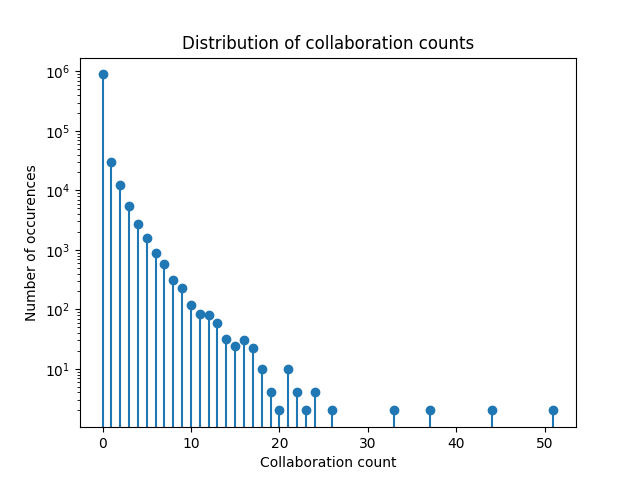

There is a total of 122 collaborations in assignments.

Hard deadline


<IPython.core.display.Javascript object>


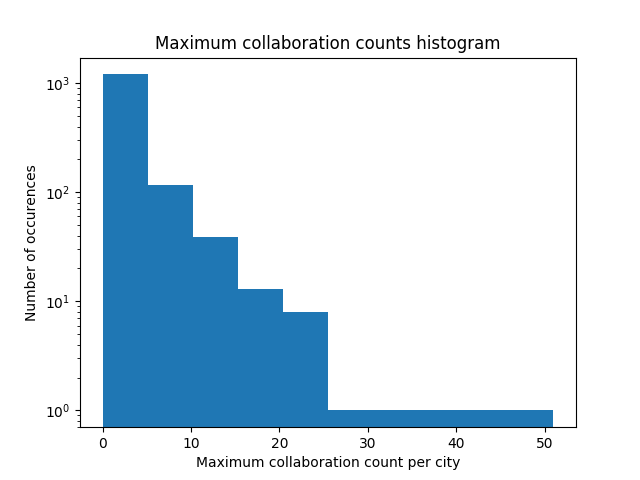

<IPython.core.display.Javascript object>


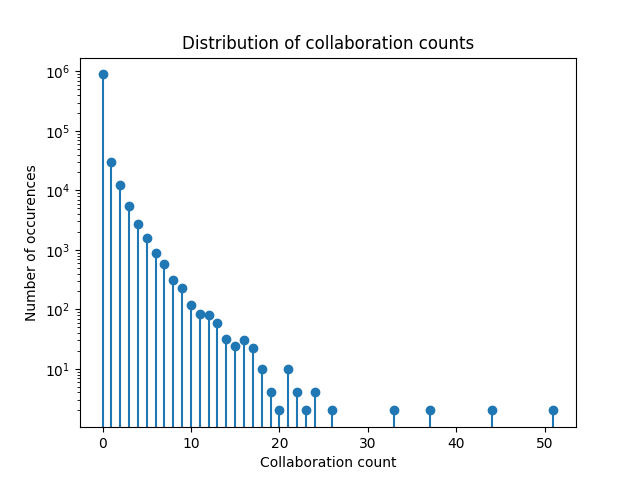

There is a total of 122 collaborations in assignments.

Soft deadline


<IPython.core.display.Javascript object>


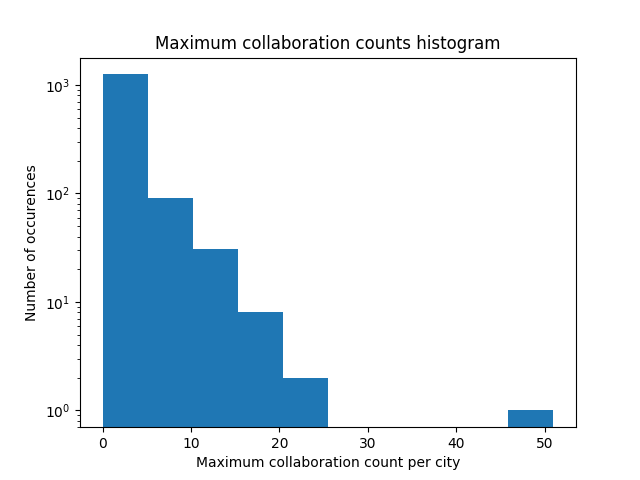

<IPython.core.display.Javascript object>


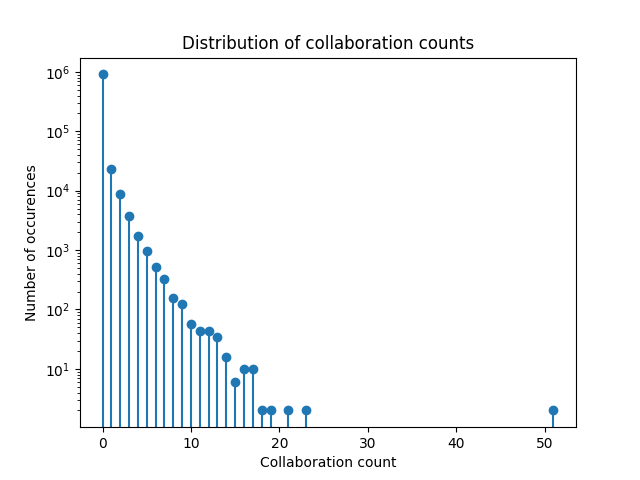

There is a total of 36 collaborations in assignments.


In [72]:
# 30 minute time window
time_window = 1800

# Get collaboration cooccurence matrices for no deadline
no_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window)
# Get collaboration cooccurence matrices for hard deadline
hard_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window,
                                                     deadline_threshold, 'HardCloseTime')
# Get collaboration cooccurence matrices for soft deadline
soft_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window,
                                                     deadline_threshold, 'SoftCloseTime')

# Draw plots for no deadline
print('No deadline')
plot_collaboration(no_deadline_mats)

# Draw plots for hard deadline
print()
print('Hard deadline')
plot_collaboration(hard_deadline_mats)

# Draw plots for soft deadline
print()
print('Soft deadline')
plot_collaboration(soft_deadline_mats)

No deadline


/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


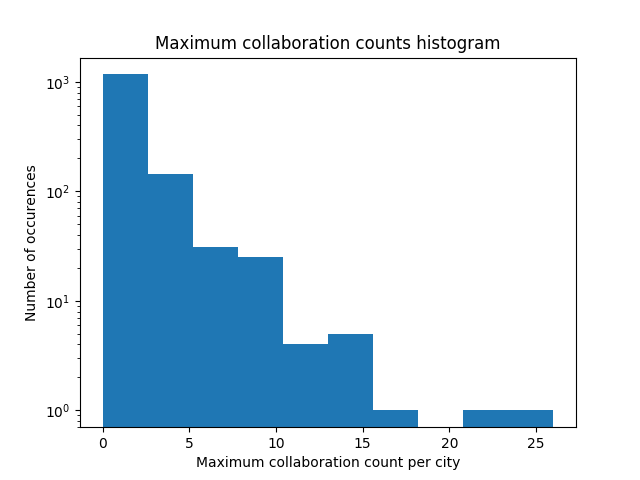

<IPython.core.display.Javascript object>


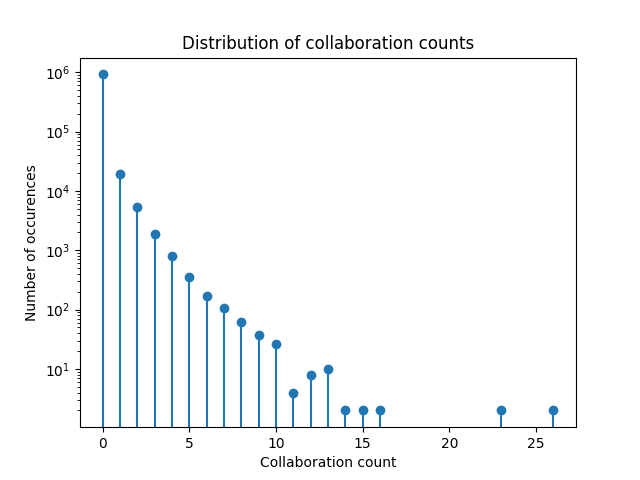

There is a total of 8 collaborations in assignments.

Hard deadline


<IPython.core.display.Javascript object>


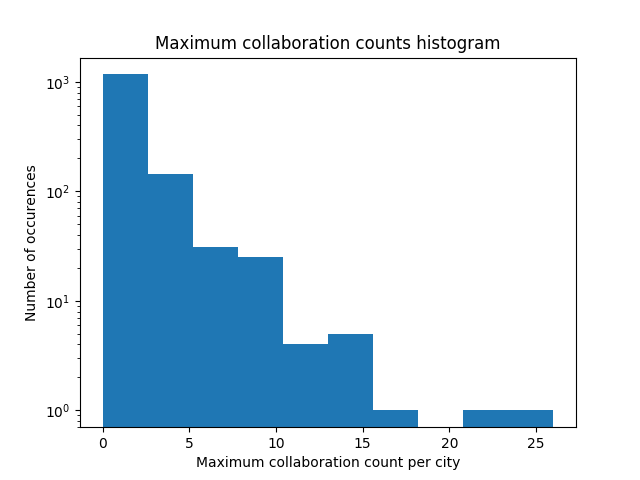

<IPython.core.display.Javascript object>


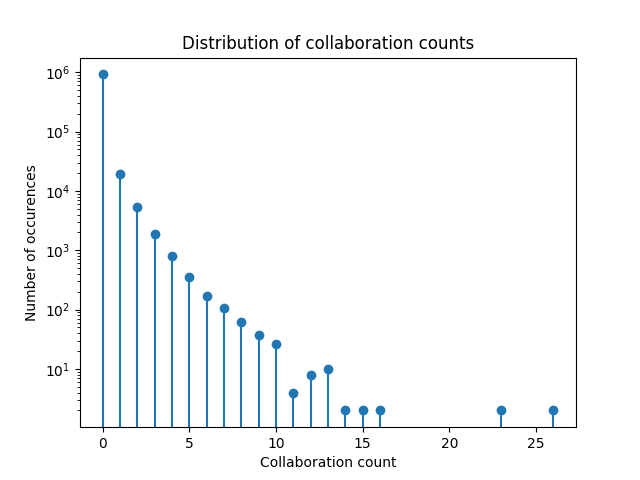

There is a total of 8 collaborations in assignments.

Soft deadline


<IPython.core.display.Javascript object>


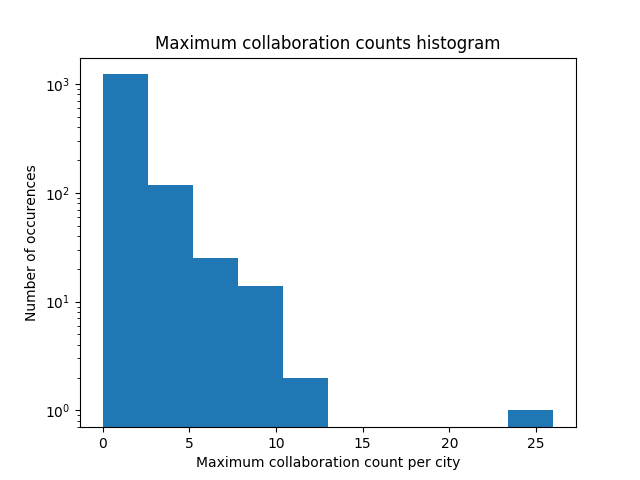

<IPython.core.display.Javascript object>


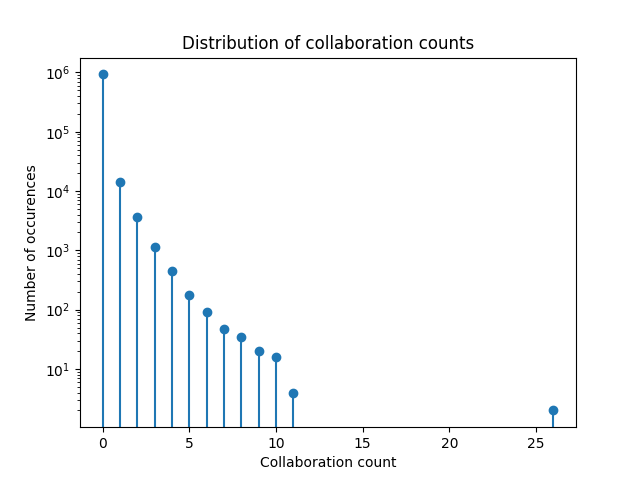

There is a total of 2 collaborations in assignments.


In [147]:
# 10 minute time window
time_window = 600

# Get collaboration cooccurence matrices for no deadline
no_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window)
# Get collaboration cooccurence matrices for hard deadline
hard_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window,
                                                     deadline_threshold, 'HardCloseTime')
# Get collaboration cooccurence matrices for soft deadline
soft_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window,
                                                     deadline_threshold, 'SoftCloseTime')

# Draw plots for no deadline
print('No deadline')
plot_collaboration(no_deadline_mats)

# Draw plots for hard deadline
print()
print('Hard deadline')
plot_collaboration(hard_deadline_mats)

# Draw plots for soft deadline
print()
print('Soft deadline')
plot_collaboration(soft_deadline_mats)

No deadline


/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


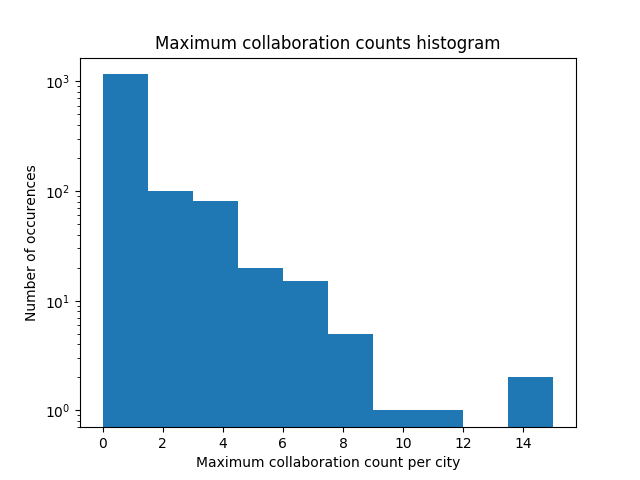

<IPython.core.display.Javascript object>


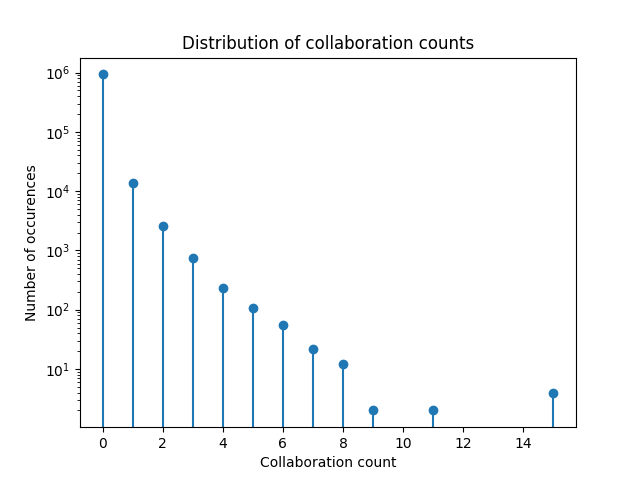

There is a total of 4 collaborations in assignments.

Hard deadline


<IPython.core.display.Javascript object>


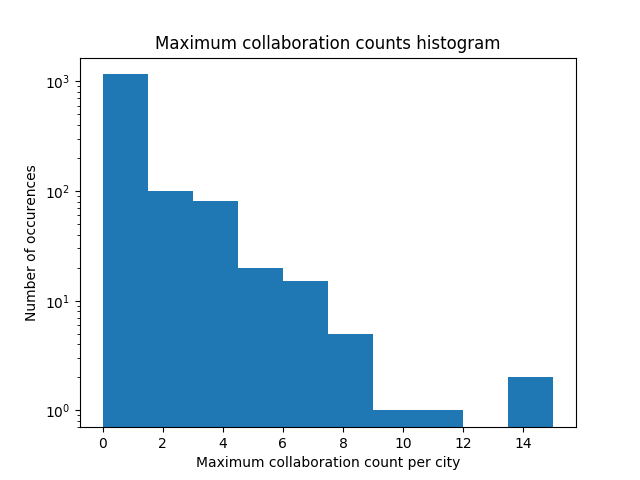

<IPython.core.display.Javascript object>


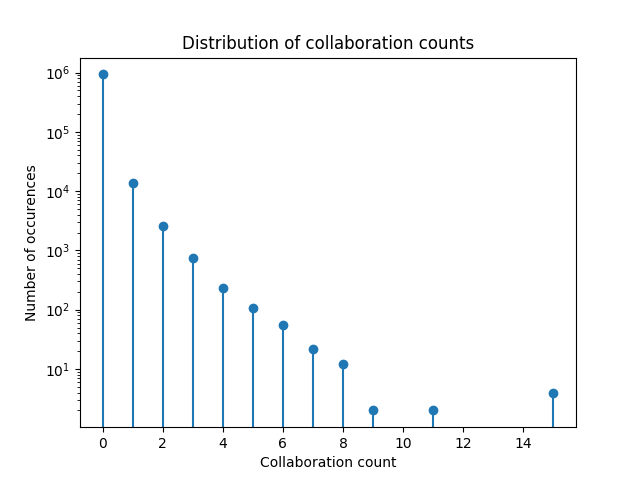

There is a total of 4 collaborations in assignments.

Soft deadline


<IPython.core.display.Javascript object>


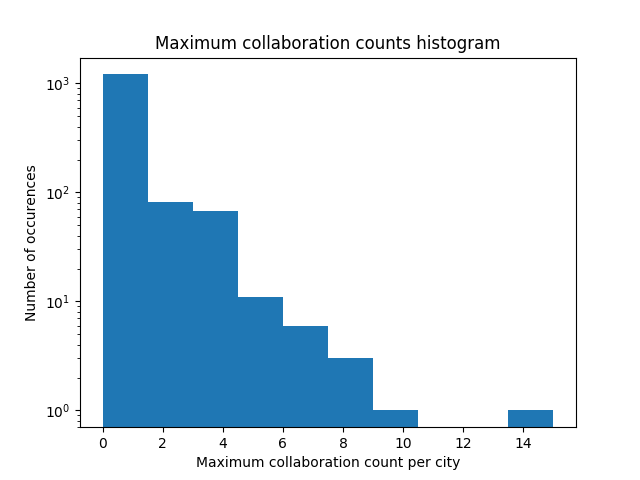

<IPython.core.display.Javascript object>


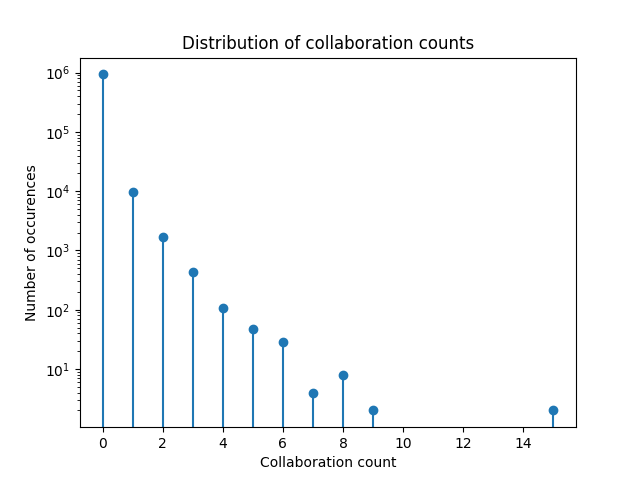

There is a total of 2 collaborations in assignments.


In [148]:
# 5 minute time window
time_window = 300

# Get collaboration cooccurence matrices for no deadline
no_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window)
# Get collaboration cooccurence matrices for hard deadline
hard_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window,
                                                     deadline_threshold, 'HardCloseTime')
# Get collaboration cooccurence matrices for soft deadline
soft_deadline_mats, _ = analyse_collaboration(assignment_sub_dfs, users_dicts, time_window,
                                                     deadline_threshold, 'SoftCloseTime')

# Draw plots for no deadline
print('No deadline')
plot_collaboration(no_deadline_mats)

# Draw plots for hard deadline
print()
print('Hard deadline')
plot_collaboration(hard_deadline_mats)

# Draw plots for soft deadline
print()
print('Soft deadline')
plot_collaboration(soft_deadline_mats)

We see that there is a drastic reduction in the number of collaborations detected (if we consider a collaboration to occur if 15 submissions overlap) as we decrease the time window, which is the expected result.

However, considering that if two people collaborate it doesn't necesarrily mean that they submit things at a very short time one after another, we say that a time window of one hour seems to be suitable.